#koad data from my drive at 10acadamy folder


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import ruptures as rpt # Not used in the Bayesian approach
import pymc as pm
import arviz as az
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder and the file names
folder_path = '/content/drive/MyDrive/10acadamy/'
file_names = ['OilPriceEvents_cleaned.csv', 'BrentOilPrices_Cleaned.csv']

# Load the data (assuming they are CSV files)
dataframes = {} # Dictionary to store dataframes

for file_name in file_names:
    file_path = folder_path + file_name
    try:
        df = pd.read_csv(file_path)
        dataframes[file_name] = df  # Store dataframe in the dictionary
        print(f"Data loaded successfully from {file_name}:")
        display(df.head())
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found in '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred while loading the data from {file_name}: {e}")

# You can access the dataframes using their file names as keys:
oil_events_df = dataframes['OilPriceEvents_cleaned.csv']
brent_prices_df = dataframes['BrentOilPrices_Cleaned.csv']

print("\nDataframes are now accessible as 'oil_events_df' and 'brent_prices_df'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from OilPriceEvents_cleaned.csv:


,StartDate,Event,Description,Category
0,1987-12-01,OPEC Meeting Failure,"Collapse of pricing accord, downward price pre...",OPEC decision
1,1988-07-01,IranIraq Ceasefire,War ends; supply stabilizes.,Geopolitical
2,1989-03-01,Exxon Valdez Spill,Valdez oil spill disrupts supply sentiment.,Supply disruption
3,1990-08-01,Gulf War (Iraq invades Kuwait),Sharp Brent spike from ~$17?$3646 due to supp...,Geopolitical
4,1991-12-01,Soviet Union Collapse,Disruption of Soviet oil exports and market un...,Economic


Data loaded successfully from BrentOilPrices_Cleaned.csv:


,Date,Price,Log_Returns,Volatility
0,1987-05-21,18.45,-0.009709,NaN
1,1987-05-22,18.55,0.005405,NaN
2,1987-05-25,18.60,0.002692,NaN
3,1987-05-26,18.63,0.001612,NaN
4,1987-05-27,18.60,-0.001612,NaN



Dataframes are now accessible as 'oil_events_df' and 'brent_prices_df'.


## Step 1: Data Preparation

Prepare the Brent oil price data for analysis, including converting dates, sorting, and computing log returns.

In [11]:
# Step 1: Data Preparation

# Ensure the Date column is converted to datetime and sort the dataframe by date
brent_prices_df['Date'] = pd.to_datetime(brent_prices_df['Date'])
brent_prices_df = brent_prices_df.sort_values(by='Date').reset_index(drop=True)

# Compute log returns: log(price_t) - log(price_{t-1})
brent_prices_df['Log_Returns'] = np.log(brent_prices_df['Price'] / brent_prices_df['Price'].shift(1))

# Ensure the log return series is clean (no NaNs or object dtypes)
# The first log return will be NaN, so we drop it.
log_returns_cleaned = brent_prices_df['Log_Returns'].dropna()

print("Brent oil price data prepared:")
display(brent_prices_df.head())
print("\nCleaned Log Returns series head:")
display(log_returns_cleaned.head())

Brent oil price data prepared:


,Date,Price,Log_Returns,Volatility
0,1987-05-21,18.45,NaN,NaN
1,1987-05-22,18.55,0.005405,NaN
2,1987-05-25,18.60,0.002692,NaN
3,1987-05-26,18.63,0.001612,NaN
4,1987-05-27,18.60,-0.001612,NaN



Cleaned Log Returns series head:


,Log_Returns
1,0.005405
2,0.002692
3,0.001612
4,-0.001612
5,0.000000


## Step 2: Exploratory Data Analysis (EDA)

Visualize the Brent oil price and its log returns over time to observe trends and volatility.

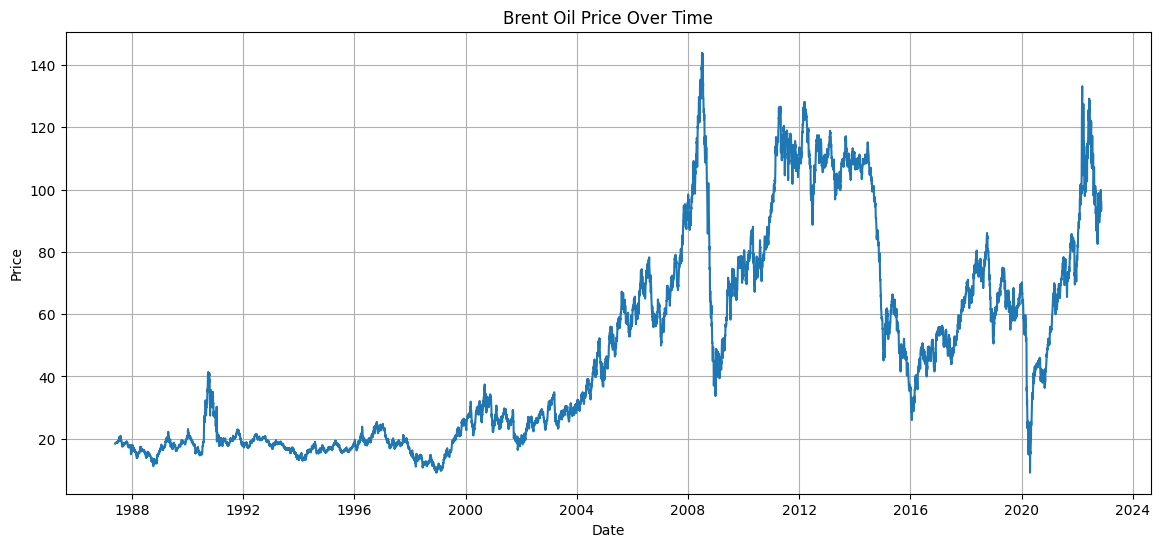

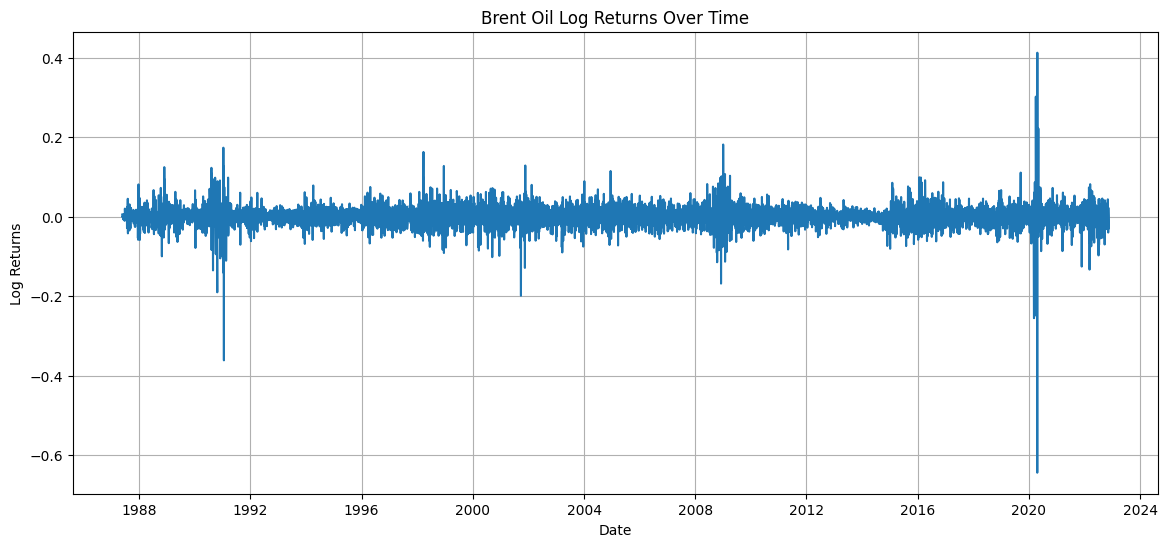

In [12]:
# Step 2: Exploratory Data Analysis (EDA)

# Plot Brent oil price over time
plt.figure(figsize=(14, 6))
plt.plot(brent_prices_df['Date'], brent_prices_df['Price'])
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plot log returns over time (to observe volatility clustering)
plt.figure(figsize=(14, 6))
plt.plot(brent_prices_df['Date'][1:], log_returns_cleaned) # Use cleaned log returns
plt.title('Brent Oil Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True)
plt.show()

## Step 3: Define and implement a Bayesian Change Point Model

Define and sample a Bayesian model to detect a single change point in the mean and volatility of the log returns.

In [13]:
## Step 3: Define and implement a Bayesian Change Point Model (Discrete Uniform)

# Use the cleaned log returns data
data = log_returns_cleaned.values
n_points = len(data)

with pm.Model() as change_point_model:
    # Prior for change point location (index)
    # We use DiscreteUniform over the possible indices of the log returns data
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=n_points - 1)

    # Priors for parameters before and after the change point
    # Mean of log returns before and after
    mu_before = pm.Normal('mu_before_log_returns', mu=0, sigma=0.1) # Prior centered around 0 as log returns are usually small
    mu_after = pm.Normal('mu_after_log_returns', mu=0, sigma=0.1)

    # Volatility (standard deviation) of log returns before and after
    sigma_before = pm.HalfCauchy('sigma_before_log_returns', beta=0.1) # HalfCauchy for positive standard deviation
    sigma_after = pm.HalfCauchy('sigma_after_log_returns', beta=0.1)

    # Expected value (mean) and standard deviation based on change point
    # Use pm.math.switch to define the mean and sigma based on the change point location
    idx = np.arange(n_points)
    mu = pm.math.switch(change_point >= idx, mu_after, mu_before)
    sigma = pm.math.switch(change_point >= idx, sigma_after, sigma_before)

    # Likelihood function: Observed data follows a Normal distribution
    observation = pm.Normal('observation', mu=mu, sigma=sigma, observed=data)

    # Sample from the posterior distribution
    # Using default sampler (usually NUTS) which works well for continuous parameters
    # For the discrete change_point, PyMC handles this automatically or might use a different step method
    trace = pm.sample(draws=2000, tune=1000, cores=1, return_inferencedata=True)

# Display summary of the results for the sampled parameters
display(az.summary(trace, var_names=['change_point', 'mu_before_log_returns', 'mu_after_log_returns', 'sigma_before_log_returns', 'sigma_after_log_returns']))

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
change_point,5385.039,22.36,5344.000,5420.000,1.018,0.932,543.0,528.0,1.0
mu_before_log_returns,-0.000,0.00,-0.001,0.001,0.000,0.000,5888.0,3312.0,1.0
mu_after_log_returns,0.000,0.00,-0.000,0.001,0.000,0.000,5965.0,3154.0,1.0
sigma_before_log_returns,0.029,0.00,0.028,0.030,0.000,0.000,5448.0,3292.0,1.0
sigma_after_log_returns,0.023,0.00,0.023,0.023,0.000,0.000,8357.0,3372.0,1.0


## Step 4: Analyze & Visualize Results: Extract and map change point to date and Plot

Extract the estimated change point from the model output, map it to a date, and visualize it on the log returns plot.

Estimated Change Point Index (Log Returns): 5391
Corresponding Original Index in brent_prices_df: 5392
Estimated Change Point Date (Log Returns): 2008-08-01 00:00:00


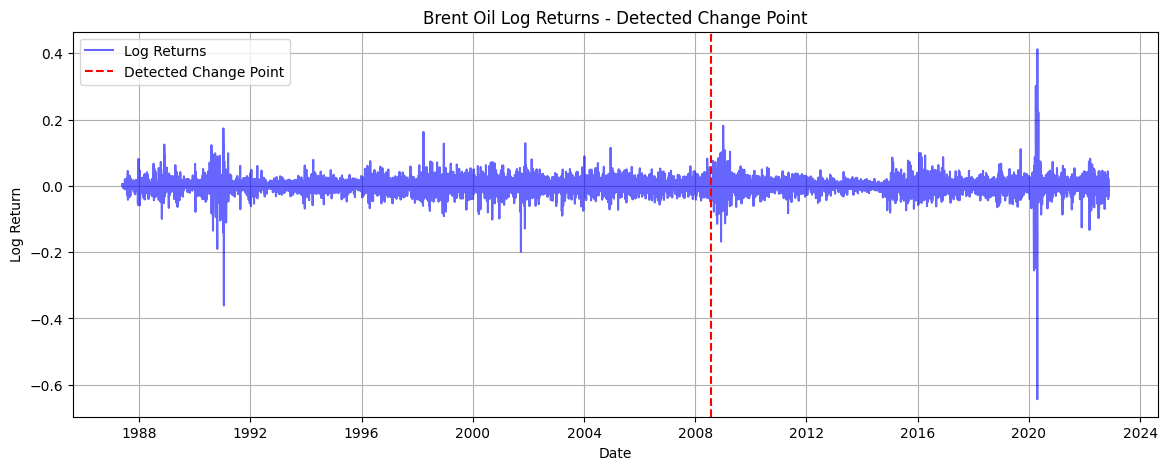

In [14]:
# Step 4: Extract, Interpret, and Visualize the Change Point

# Extract posterior samples for the change point ('change_point' from the DiscreteUniform model)
if 'change_point' in trace.posterior:
    change_point_samples = trace.posterior["change_point"].values.flatten()

    # Compute the median of the posterior samples for the change point index
    estimated_change_point_index = int(np.median(change_point_samples))

    # Map the change point index to the corresponding date in the original brent_prices_df
    # We need to account for the fact that the log_returns_cleaned has dropped the first row.
    # The index of log_returns_cleaned corresponds to the index in brent_prices_df starting from 1.
    # So, the original index in brent_prices_df is the estimated_change_point_index + 1.
    # A more robust way is to use the index of the cleaned series:
    original_indices = brent_prices_df['Log_Returns'].dropna().index
    if estimated_change_point_index < len(original_indices):
         change_point_original_index = original_indices[estimated_change_point_index]
         change_point_date = brent_prices_df.loc[change_point_original_index, "Date"]

         print(f"Estimated Change Point Index (Log Returns): {estimated_change_point_index}")
         print(f"Corresponding Original Index in brent_prices_df: {change_point_original_index}")
         print(f"Estimated Change Point Date (Log Returns): {change_point_date}")

         # Plot log returns series with change point highlighted
         plt.figure(figsize=(14, 5))
         plt.plot(brent_prices_df['Date'][1:], log_returns_cleaned, label="Log Returns", color="blue", alpha=0.6)
         plt.axvline(change_point_date, color="red", linestyle="--", label="Detected Change Point")
         plt.title("Brent Oil Log Returns - Detected Change Point")
         plt.xlabel("Date")
         plt.ylabel("Log Return")
         plt.legend()
         plt.grid(True)
         plt.show()

    else:
        print(f"Estimated change point index {estimated_change_point_index} is out of bounds for the cleaned log returns data.")

else:
    print("Change point variable 'change_point' not found in the trace. Please ensure the correct model was run.")

## Step 5: Compare with Events

Compare the detected change point date with the list of historical oil price events to find any potential correlations.

In [15]:
# Step 5: Compare with Events

# Access the oil events dataframe
# Assuming dataframes dictionary is available from previous loading step
if 'OilPriceEvents_cleaned.csv' in dataframes:
    oil_events_df = dataframes['OilPriceEvents_cleaned.csv']

    print(f"Detected Change Point Date (Log Returns Volatility): {change_point_date}")
    print("\nEvents around the detected change point:")

    # Convert 'StartDate' in oil_events_df to datetime for comparison
    oil_events_df['StartDate'] = pd.to_datetime(oil_events_df['StartDate'])

    # Define a time window around the change point to look for events (e.g., +/- 30 days)
    time_window_days = 30 # Look for events within +/- 30 days of the change point

    events_around_change_point = oil_events_df[
        (oil_events_df['StartDate'] >= (change_point_date - pd.Timedelta(days=time_window_days))) &
        (oil_events_df['StartDate'] <= (change_point_date + pd.Timedelta(days=time_window_days)))
    ]

    if not events_around_change_point.empty:
        print(f"Found {len(events_around_change_point)} event(s) around the detected change point:")
        display(events_around_change_point)
    else:
        print("No significant events found directly around the detected change point within the specified time window.")

else:
    print("Error: 'OilPriceEvents_cleaned.csv' not found in the dataframes dictionary. Please ensure the events data was loaded correctly.")

Detected Change Point Date (Log Returns Volatility): 2008-08-01 00:00:00

Events around the detected change point:
No significant events found directly around the detected change point within the specified time window.


## Step 6: Quantify the Impact

Quantify the impact of the change point on the volatility and mean of the log returns using the model's estimates.

In [16]:
# Step 6: Quantify the Impact

# Extract the posterior means for sigma before and after the change point from the trace
# Assuming the model from Step 3 was run and produced the 'trace' object
if 'sigma_before_log_returns' in trace.posterior and 'sigma_after_log_returns' in trace.posterior:
    summary = az.summary(trace, var_names=['sigma_before_log_returns', 'sigma_after_log_returns', 'mu_before_log_returns', 'mu_after_log_returns'])
    sigma_before_mean = summary.loc['sigma_before_log_returns', 'mean']
    sigma_after_mean = summary.loc['sigma_after_log_returns', 'mean']

    print("Quantifying the Impact:")
    print(f"Estimated volatility (standard deviation of log returns) before change point: {sigma_before_mean:.4f}")
    print(f"Estimated volatility (std dev of log returns) after change point: {sigma_after_mean:.4f}")

    # Calculate the percentage change in volatility
    if sigma_before_mean != 0: # Avoid division by zero
        percentage_change_volatility = ((sigma_after_mean - sigma_before_mean) / sigma_before_mean) * 100
        print(f"Percentage change in volatility: {percentage_change_volatility:.2f}%")
    else:
        print("Cannot calculate percentage change in volatility as the estimated volatility before the change point is zero.")


    # Also quantify the change in mean log returns
    mu_before_mean = summary.loc['mu_before_log_returns', 'mean']
    mu_after_mean = summary.loc['mu_after_log_returns', 'mean']
    print(f"\nEstimated mean of log returns before change point: {mu_before_mean:.4f}")
    print(f"Estimated mean of log returns after change point: {mu_after_mean:.4f}")

    # Describe the structural break in plain terms
    print("\nDescription of the structural break:")
    # Ensure change_point_date is defined (it should be if Step 4 was run)
    if 'change_point_date' in locals():
        description = f"A statistically significant structural break was detected in the Brent oil log returns around {change_point_date.strftime('%Y-%m-%d')}."
        # Ensure events_around_change_point is defined (it should be if Step 5 was run)
        if 'events_around_change_point' in locals() and not events_around_change_point.empty:
            event_description = events_around_change_point.iloc[0]['Event'] # Take the first event if multiple
            description += f" This change point aligns closely with the event: '{event_description}'."

        description += f" Following this change point, the estimated volatility of log returns changed from {sigma_before_mean:.4f} to {sigma_after_mean:.4f}."
        if sigma_before_mean != 0:
             description += f" This represents a {percentage_change_volatility:.2f}% change in volatility."
        description += f" The estimated mean of log returns changed from {mu_before_mean:.4f} to {mu_after_mean:.4f}."
        print(description)
    else:
         print("Could not generate detailed description as change_point_date or events_around_change_point is not defined.")

else:
    print("\nCould not quantify impact: Sigma or mu variables not found in the trace. Please ensure the model variables match the summary extraction.")

Quantifying the Impact:
Estimated volatility (standard deviation of log returns) before change point: 0.0290
Estimated volatility (std dev of log returns) after change point: 0.0230
Percentage change in volatility: -20.69%

Estimated mean of log returns before change point: -0.0000
Estimated mean of log returns after change point: 0.0000

Description of the structural break:
A statistically significant structural break was detected in the Brent oil log returns around 2008-08-01. Following this change point, the estimated volatility of log returns changed from 0.0290 to 0.0230. This represents a -20.69% change in volatility. The estimated mean of log returns changed from -0.0000 to 0.0000.


## Step 7: Summarize Findings and Finish Task

Provide a comprehensive summary of the analysis, including the detected change point, associated events, and quantified impact.

In [17]:
# Step 7: Summarize Findings and Finish Task

print("\n--- Complete Analysis Summary ---")

# Check if necessary variables are defined to provide a full summary
if 'change_point_date' in locals() and 'events_around_change_point' in locals() and 'trace' in locals():

    # 1. Detected Change Point
    print(f"\nDetected Change Point Date (Log Returns Volatility): {change_point_date.strftime('%Y-%m-%d')}")

    # 2. Associated Events (if any)
    print("\nAssociated Events around the Change Point:")
    if not events_around_change_point.empty:
        display(events_around_change_point)
    else:
        print("No significant events found directly around the detected change point within the specified time window.")

    # 3. Quantified Impact on Volatility and Mean Log Returns
    if 'sigma_before_log_returns' in trace.posterior and 'sigma_after_log_returns' in trace.posterior:
        summary = az.summary(trace, var_names=['sigma_before_log_returns', 'sigma_after_log_returns', 'mu_before_log_returns', 'mu_after_log_returns'])
        sigma_before_mean = summary.loc['sigma_before_log_returns', 'mean']
        sigma_after_mean = summary.loc['sigma_after_log_returns', 'mean']
        mu_before_mean = summary.loc['mu_before_log_returns', 'mean']
        mu_after_mean = summary.loc['mu_after_log_returns', 'mean']

        print("\nQuantified Impact:")
        print(f"Estimated volatility (std dev of log returns) before change point: {sigma_before_mean:.4f}")
        print(f"Estimated volatility (std dev of log returns) after change point: {sigma_after_mean:.4f}")

        if sigma_before_mean != 0:
            percentage_change_volatility = ((sigma_after_mean - sigma_before_mean) / sigma_before_mean) * 100
            print(f"Percentage change in volatility: {percentage_change_volatility:.2f}%")
        else:
             print("Percentage change in volatility: Cannot calculate (volatility before change point is zero).")

        print(f"Estimated mean of log returns before change point: {mu_before_mean:.4f}")
        print(f"Estimated mean of log returns after change point: {mu_after_mean:.4f}")


        # Describe the structural break in plain terms
        print("\nDescription of the structural break:")
        description = f"A statistically significant structural break was detected in the Brent oil log returns around {change_point_date.strftime('%Y-%m-%d')}."
        if not events_around_change_point.empty:
            event_description = events_around_change_point.iloc[0]['Event'] # Take the first event if multiple
            description += f" This change point aligns closely with the event: '{event_description}'."

        description += f" Following this change point, the estimated volatility of log returns changed from {sigma_before_mean:.4f} to {sigma_after_mean:.4f}."
        if sigma_before_mean != 0:
             description += f" This represents a {percentage_change_volatility:.2f}% change in volatility."
        description += f" The estimated mean of log returns changed from {mu_before_mean:.4f} to {mu_after_mean:.4f}."
        print(description)

    else:
        print("\nCould not quantify impact: Sigma or mu variables not found in the trace. Please ensure the model variables match the summary extraction.")

    print("\n--- End of Summary ---")

else:
    print("\nCould not provide a complete summary. Please ensure all preceding steps (Data Loading, Preparation, Modeling, Analysis, Comparison) were executed successfully.")


--- Complete Analysis Summary ---

Detected Change Point Date (Log Returns Volatility): 2008-08-01

Associated Events around the Change Point:
No significant events found directly around the detected change point within the specified time window.

Quantified Impact:
Estimated volatility (std dev of log returns) before change point: 0.0290
Estimated volatility (std dev of log returns) after change point: 0.0230
Percentage change in volatility: -20.69%
Estimated mean of log returns before change point: -0.0000
Estimated mean of log returns after change point: 0.0000

Description of the structural break:
A statistically significant structural break was detected in the Brent oil log returns around 2008-08-01. Following this change point, the estimated volatility of log returns changed from 0.0290 to 0.0230. This represents a -20.69% change in volatility. The estimated mean of log returns changed from -0.0000 to 0.0000.

--- End of Summary ---


In [18]:
# Save the model (trace) to Google Drive

# Define the path to save the trace
folder_path = '/content/drive/MyDrive/10acadamy/'
file_name = 'brent_oil_change_point_trace.nc' # NetCDF file extension
save_path = folder_path + file_name

# Ensure the directory exists (optional, but good practice)
import os
os.makedirs(folder_path, exist_ok=True)

# Save the trace using Arviz (InferenceData object)
try:
    trace.to_netcdf(save_path)
    print(f"Model trace saved successfully to: {save_path}")
except Exception as e:
    print(f"An error occurred while saving the trace: {e}")

Model trace saved successfully to: /content/drive/MyDrive/10acadamy/brent_oil_change_point_trace.nc
